In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np

import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import helper

data_dir = '/home/vansh/Downloads/artwork-data/'

In [2]:
# check for GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Apr  1 22:30:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P3              N/A /  55W |      8MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Add noise to each image with a normal distribution
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [4]:
# Image augmentation

# TRAIN Sets
# Plain
transform_train_default = transforms.Compose([
                                transforms.Resize(750),
                                transforms.CenterCrop(750),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
                                ])
# Flipped
transform_train_vflip = transforms.Compose([
                                transforms.Resize(750),
                                transforms.CenterCrop(750),
                                transforms.RandomVerticalFlip(p=1),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
                                ])
# Color jittered
transform_train_jitter = transforms.Compose([
                                transforms.Resize(750),
                                transforms.CenterCrop(750),
                                transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0, hue=0),
                                transforms.ToTensor()
                                ])
# Gaussian noise
transform_train_gaussian = transforms.Compose([
                                transforms.Resize(750),
                                transforms.CenterCrop(750),
                                transforms.ToTensor(),
                                AddGaussianNoise(0.1, 0.08)
                                ])
# Randomly cropped
transform_train_crop = transforms.Compose([
                                transforms.Resize(1000),
                                transforms.RandomCrop(750),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
                                ])
# TEST Set
transform_test = transforms.Compose([
                                transforms.Resize(750),
                                transforms.CenterCrop(750),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
                                ])

# Import images with each of the transformation methods
dataset_train_default = datasets.ImageFolder(data_dir + 'images/images', transform=transform_train_default)
dataset_train_vflip = datasets.ImageFolder(data_dir + 'images/images', transform=transform_train_vflip)
dataset_train_jitter = datasets.ImageFolder(data_dir + 'images/images', transform=transform_train_jitter)
dataset_train_gaussian = datasets.ImageFolder(data_dir + 'images/images', transform=transform_train_gaussian)
dataset_train_crop = datasets.ImageFolder(data_dir + 'images/images', transform=transform_train_crop)

# Concatenate train datasets
dataset_train = torch.utils.data.ConcatDataset((dataset_train_default, dataset_train_vflip, dataset_train_jitter, dataset_train_gaussian, dataset_train_crop))

# Import images with test transformation
dataset_test = datasets.ImageFolder(data_dir + 'images/images', transform=transform_test)

In [5]:
len(dataset_train)

43870

In [6]:
# Classes
classes_train, classes_test = dataset_train_default.classes, dataset_test.classes
classes = classes_train
len(classes_train), len(classes_test)

(51, 51)

### Split into train and test

In [7]:
# train test split
test_size = 0.1

# initialize counter
class_counter = [0] * 51

# Count number of images for each class
for idx, (path, artist_class) in enumerate(dataset_train_default.imgs):
  class_counter[artist_class] += 1

train_idx, test_idx = [], []
aggregate = 0
train_len = len(dataset_train_default)

for class_count in class_counter:
  split = int(np.floor(test_size * class_count))
  indices = list(range(class_count))
  train_idx_local, test_idx_local = indices[split:aggregate], indices[:split]

  # Get the indeces for all the training data, the original and the augmented images
  train_idx_tuples = [(x + aggregate, train_len + x + aggregate, 2 * train_len + x + aggregate, 3 * train_len + x + aggregate, 4 * train_len + x + aggregate) for x in train_idx_local]
  train_idx += [i for sub in train_idx_tuples for i in sub]
  
  # Get the indeces for the test images
  test_idx += [x + aggregate for x in test_idx_local]
  aggregate += class_count

print(len(train_idx), len(test_idx))

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

38125 853


In [8]:
print(test_idx)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1479, 1480, 1481, 1482, 1483, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 182

## Load images

In [9]:
batch_size = 24

In [10]:
# Load test images with train indeces
train_dataloader = torch.utils.data.DataLoader(
  dataset_train, batch_size=batch_size, sampler=train_sampler,
  num_workers=2
)

# Load test images
test_dataloader = torch.utils.data.DataLoader(
  dataset_test, batch_size=batch_size, sampler=test_sampler,
  num_workers=2
)

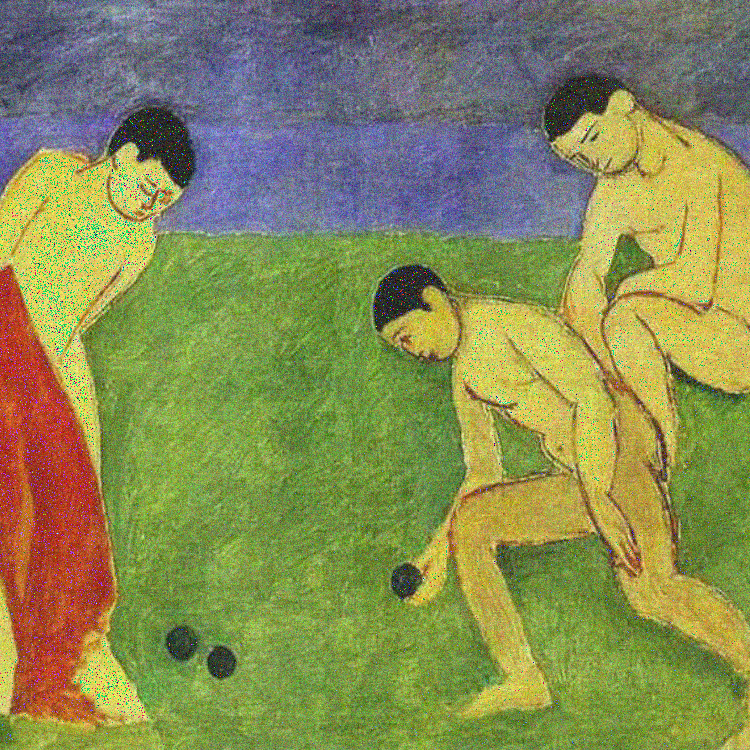

In [11]:
# Display an example image
images, labels = next(iter(train_dataloader))
transforms.functional.to_pil_image(images[15])

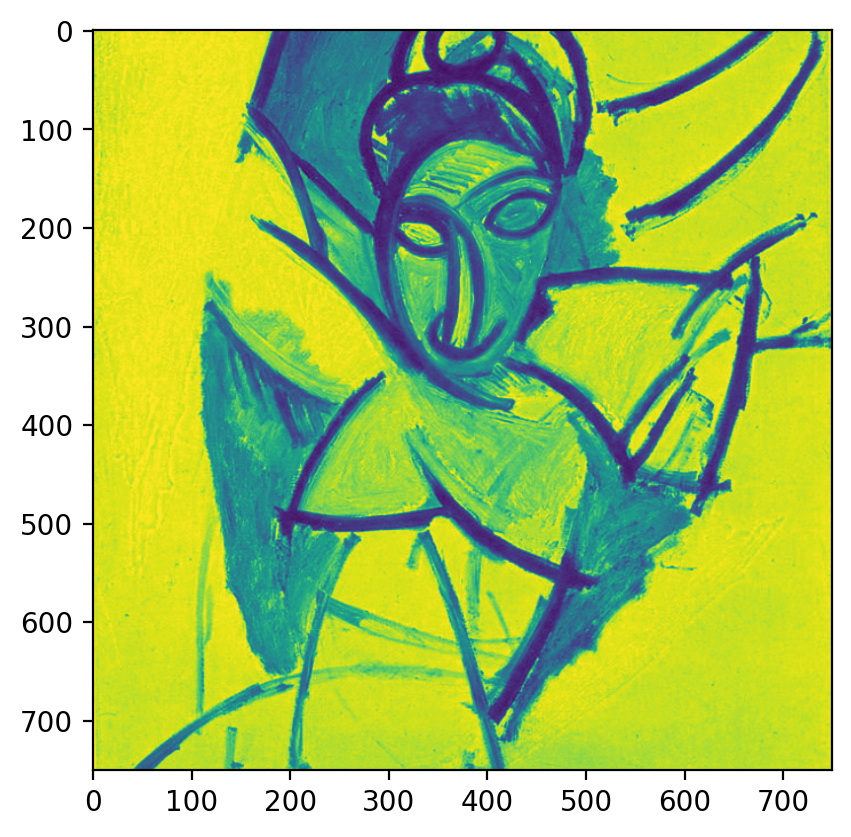

The label of the image is: 34


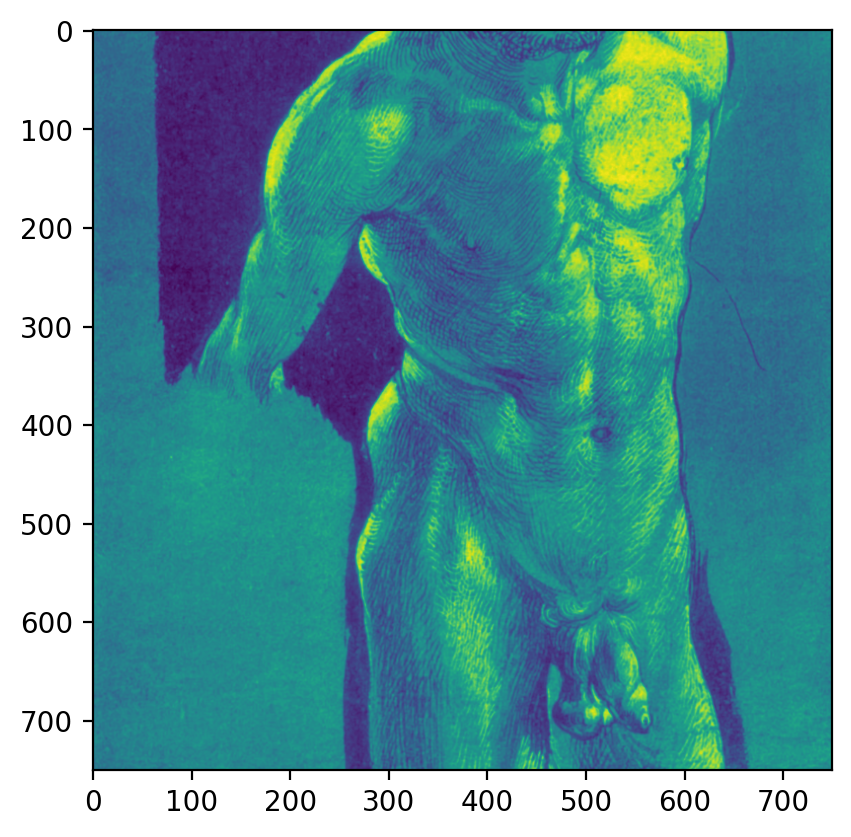

The label of the image is: 0


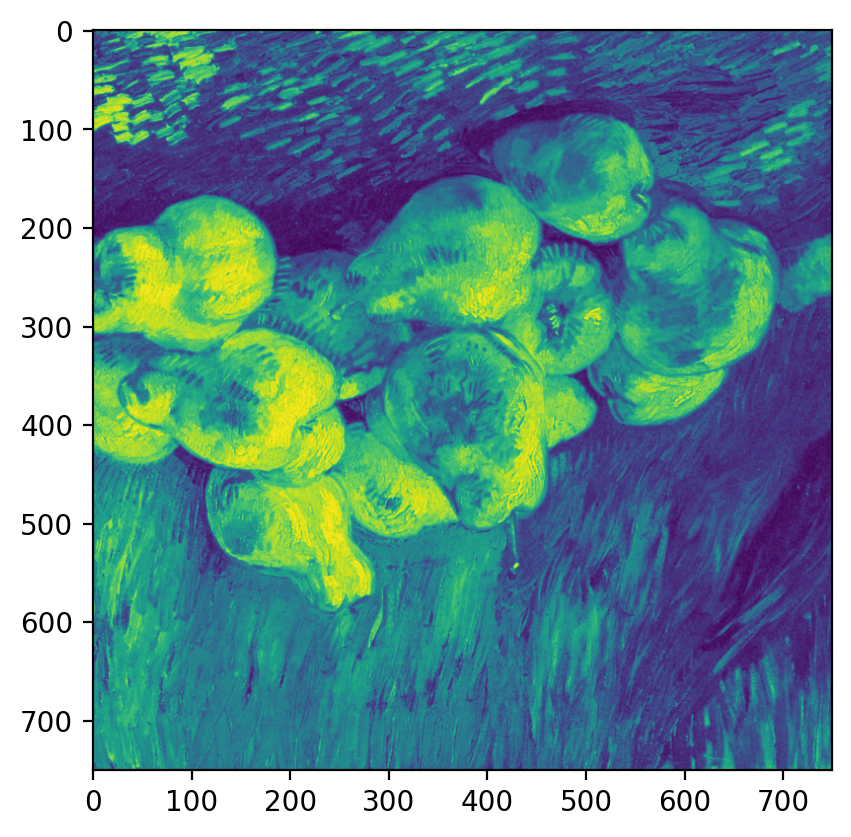

The label of the image is: 49


In [12]:
import random

# Print 3 random images in their augmented and normalized state

rand_numer1 = random.randint(0,25338)
plt.imshow(dataset_train[rand_numer1][0][0])
plt.show()
print("The label of the image is:", dataset_train[rand_numer1][1])

rand_numer2 = random.randint(0,25338)
plt.imshow(dataset_train[rand_numer2][0][0])
plt.show()
print("The label of the image is:", dataset_train[rand_numer2][1])

rand_numer3 = random.randint(0,25338)
plt.imshow(dataset_train[rand_numer3][0][0])
plt.show()
print("The label of the image is:", dataset_train[rand_numer3][1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


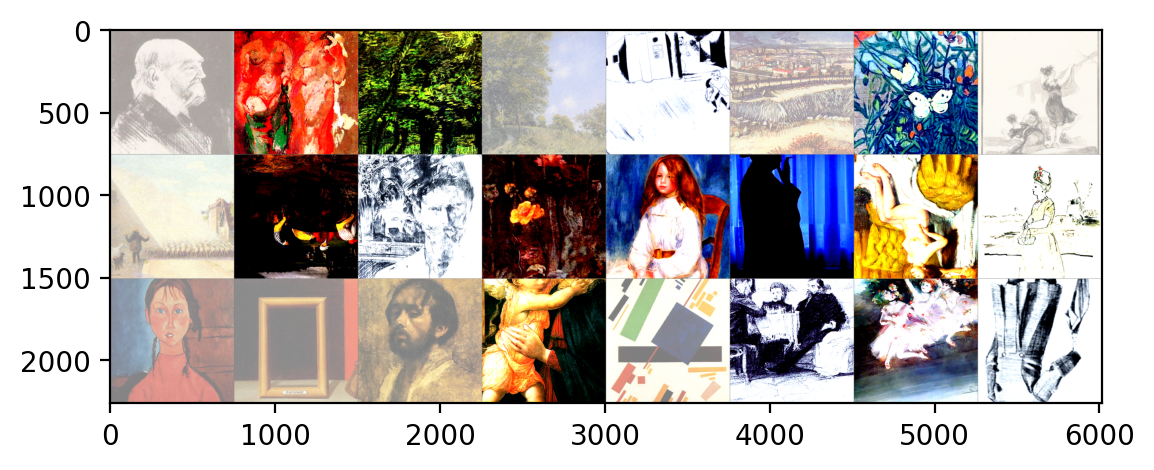

Vincent_van_Gogh Pablo_Picasso Vincent_van_Gogh Alfred_Sisley


In [13]:
batch_size = 4
import numpy as np

# show image unnormalized
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
images, labels = next(iter(train_dataloader))
# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## Import artists

In [14]:
# import artists data
artists = pd.read_csv(data_dir + '/artists.csv')
artists.shape

(50, 8)

In [15]:
# display some of the artists sorted by number of paintings
artists.sort_values(by='paintings').head()

id              name        years                   genre nationality  \
49  49   Jackson Pollock  1912 – 1956  Abstract Expressionism    American   
39  39  Eugene Delacroix  1798 – 1863             Romanticism      French   
41  41    Georges Seurat  1859 – 1891      Post-Impressionism      French   
38  38      Paul Cezanne  1839 – 1906      Post-Impressionism      French   
48  48      Michelangelo  1475 – 1564        High Renaissance     Italian   

                                                  bio  \
49  Paul Jackson Pollock (; January 28, 1912 – Aug...   
39  Ferdinand Victor Eugène Delacroix (; French: [...   
41  Georges-Pierre Seurat (French: [ʒɔʁʒ pjɛʁ sœʁa...   
38  Paul Cézanne (US:  or UK: ; French: [pɔl sezan...   
48  Michelangelo di Lodovico Buonarroti Simoni or ...   

                                         wikipedia  paintings  
49    http://en.wikipedia.org/wiki/Jackson_Pollock         24  
39  https://en.wikipedia.org/wiki/Eugène_Delacroix         31  
41    https://en.wikipedia.org/wiki/Georges_Seurat         43  
38      https://en.wikipedia.org/wiki/Paul_Cézanne         47  
48      https://en.wikipedia.org/wiki/Michelangelo         49

## Load a neural network

In [16]:
import torch.nn as nn
import torch.nn.functional as F

Load pretrained CNN

In [ ]:
# Empty cuda cache
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

In [17]:
# Load pretrained neural network we can test it on different neural networks.

# net = torchvision.models.resnet18(pretrained=True)
net = torch.hub.load('pytorch/vision:v0.11.0', 'resnet34', pretrained=True)
# net = torchvision.models.vgg16(pretrained=True)
# net = net.cuda() if torch.device else net

Using cache found in /home/vansh/.cache/torch/hub/pytorch_vision_v0.11.0
/home/vansh/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vansh/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Define a Loss function and Optimizer

In [18]:
import torch.optim as optim

# set criterion to cross entropy loss and optimizer to stochastic gradient descent
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

## Train the network

In [ ]:
# loop over the dataset multiple times
for epoch in range(5):  

    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dataloader):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 0.5)
        optimizer.step() 

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 8.515
[1,    20] loss: 7.998
[1,    30] loss: 7.253
[1,    40] loss: 6.433
[1,    50] loss: 6.088
[1,    60] loss: 5.558
[1,    70] loss: 4.988
[1,    80] loss: 4.936
[1,    90] loss: 4.458
[1,   100] loss: 4.186
[1,   110] loss: 4.110
[1,   120] loss: 3.956
[1,   130] loss: 3.765
[1,   140] loss: 3.752
[1,   150] loss: 3.378
[1,   160] loss: 3.094
[1,   170] loss: 3.471
[1,   180] loss: 2.844
[1,   190] loss: 3.056
[1,   200] loss: 2.895
[1,   210] loss: 3.085
[1,   220] loss: 2.981
[1,   230] loss: 2.565
[1,   240] loss: 2.640
[1,   250] loss: 2.484
[1,   260] loss: 2.793
[1,   270] loss: 2.747
[1,   280] loss: 2.731
[1,   290] loss: 2.640
[1,   300] loss: 2.597
[1,   310] loss: 2.506
[1,   320] loss: 2.385
[1,   330] loss: 2.457
[1,   340] loss: 2.348
[1,   350] loss: 2.373
[1,   360] loss: 2.320
[1,   370] loss: 2.217
[1,   380] loss: 2.338
[1,   390] loss: 2.322
[1,   400] loss: 2.261
[1,   410] loss: 2.179
[1,   420] loss: 2.229
[1,   430] loss: 1.854
[1,   440] 

In [ ]:
# Save the model to disk
PATH = './model.pth'
torch.save(net.state_dict(), PATH)

Test the network

In [ ]:
data_iter = iter(test_dataloader)
images, labels = data_iter.next()

# print images
transforms.functional.to_pil_image(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
# Load trained model from file
net.load_state_dict(torch.load(data_dir + '/final_model.pth'))

In [ ]:
# Make predictions
outputs = net(images.to(torch.device('cuda')))

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

### Accuracy

In [ ]:
correct = 0
total = 0

# Calculate accuracy user test data
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images.to(torch.device('cuda')))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(torch.device('cuda'))).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

### Accuracy by class

In [ ]:
# Calculate accuracy by class
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = net(images.to(torch.device('cuda')))
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels.to(torch.device('cuda')), predictions):
          if label == prediction:
              correct_pred[classes[label]] += 1
          # else:
          #   if classes[label] == 'Albrecht_Dürer':
          #     print('incorrect: ', classes[label], '!=', classes[prediction])
          total_pred[classes[label]] += 1


class_accuracies = []

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

In [ ]:
classes_plot = []
accuracy_plot = []

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    
    classes_plot.append(classname)
    accuracy_plot.append(accuracy)

In [ ]:
sorted_list = sorted(list(zip(classes_plot, accuracy_plot)), key=lambda x: x[1], reverse=True)

In [ ]:
classes_sorted, accuracies_sorted = map(list, zip(*sorted_list))

In [ ]:
# Display accuracy by artist bar plot - sorted by accuracy
figure(figsize=(15, 4), dpi=80)

x_pos = [i for i, _ in enumerate(classes_sorted)]

plt.bar(x_pos, accuracies_sorted, color='green')
plt.xlabel("Artists")
plt.ylabel("Accuracy")
plt.title("Correct classification of famous paintings")

plt.xticks(x_pos, classes_sorted)
plt.xticks(rotation=45, ha="right")

plt.show()

In [ ]:
import matplotlib.image as mpimg

def imshow(img, ax):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))

# DEMO
# Pick 4 random images, classify them and compare to label data
with torch.no_grad():
    for idx, data in enumerate(test_dataloader):
        images, labels = data
        outputs = net(images.to(torch.device('cuda')))
        _, predictions = torch.max(outputs, 1)

        if idx == 5 or idx == 10 or idx == 20 or idx == 30:
          f, axes = plt.subplots(1, 2, figsize=(20, 10))
          imshow(images[1], axes[0])
          
          if classes[labels[1]] == classes[predictions[1]]:
            axes[1].imshow(mpimg.imread(data_dir + '/green-tick.svg.png'))
          else:
            axes[1].imshow(mpimg.imread(data_dir + '/red-x.svg.png'))
          
          plt.show()
          print("The label of the image is:", classes[labels[1]])
          print("The prediction of the image is:", classes[predictions[1]], "\n\n")